In [12]:
import os
import sys
import re
import glob
import pickle
import itertools

import numpy as np
import pandas as pd
from matplotlib.ticker import LogLocator, LogFormatterMathtext
import seaborn as sns

import matplotlib.pyplot as plt
import cartopy.feature as cfeature

from tqdm import tqdm

import geopandas as gpd
import cmocean

from scipy import stats, optimize as opt, signal
from scipy.special import hyp2f1
from matplotlib.colors import TwoSlopeNorm, LogNorm
from matplotlib.ticker import (
    ScalarFormatter, AutoMinorLocator, MultipleLocator, NullFormatter
)

import cartopy.crs as ccrs

# Figure settings
golden = (1 + 5 ** 0.5) / 2
cms = 0.393701
figsizes = {
    "1 column": (3.43, 3.43 / golden),
    "1.5 columns": (4.49, 4.49 / golden),
    "2 columns": (7.01, 7.01 / golden)
}

sns.set_theme(
    rc={
        'figure.figsize': figsizes["2 columns"],
        'figure.dpi': 200,
        'savefig.dpi': 300
    },
    font="Helvetica Neue",
    font_scale=1.3,
    style="ticks"
)

plt.rcParams.update({
    'legend.edgecolor': 'k',
    'legend.facecolor': 'w',
    'legend.frameon': True,
    'legend.framealpha': 1,
    'legend.fancybox': False,
    'legend.fontsize': 12,
    'axes.linewidth': 1.5,
    'axes.edgecolor': 'k',
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'axes.labelsize': 14,
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "text.latex.preamble": r"\usepackage{amsmath, helvet} \renewcommand{\familydefault}{\sfdefault}"
})

palettename = 'coolwarm'
palette_temp = sns.color_palette(palettename, 32)

# Color palettes
paletteTGB = ['#4caf50', '#504B43', '#948d99']
metaTcolor, metaGcolor, metaBcolor = paletteTGB
metacolor = {'metaT': metaTcolor, 'metaG': metaGcolor, 'metaB': metaBcolor}
metamarker = {'metaT': 'o', 'metaG': 'd', 'metaB': 's'}

# Load world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Jupyter autoreload
%reload_ext autoreload
%autoreload 1


In [13]:
def log_hist(data, nbins=30):    
    data_positive = data[data > 0]
    bins = np.logspace(np.log10(data_positive.min()), np.log10(data_positive.max()), nbins)
    counts = np.histogram(data_positive, bins=bins)[0]
    prob = counts / counts.sum()
    pdf = prob / np.diff(bins)
    return bins, counts, prob, pdf

def return_color_station(station, metadata, palette_temp=palette_temp):
    # if station is a string convert to integer
    if isinstance(station, str):
        station = int(station)
    temperature = int(metadata.loc[station, 'temp_woa'])+1
    return palette_temp[temperature]

def plot_logSAD(data, nbins=20):
    bins, counts, prob, pdf = log_hist(data, nbins=nbins)
    xx = np.sqrt(bins[:-1]*bins[1:])
    yy = pdf
    xx = xx[yy>0]
    yy = yy[yy>0]
    return xx, yy

def plot_logrescaledSAD(data, nbins=20):
    data = data[data>0]
    y = np.log(data)
    z = (y-np.mean(y))/np.std(y)
    hist, bins = np.histogram(z, bins=nbins, density=True)
    xx = (bins[1:] + bins[:-1])/2
    yy = hist
    xx = xx[yy>0]
    yy = yy[yy>0]
    return xx, yy

def paretoDistribution(x, k, a, c, mu):
    if x >= mu:
        pdf = (k**(-1/c) * a * (1 + ((x - mu)/k)**(1/c))**(-1 - a) * (x - mu)**(-1 + 1/c)) / c
    else:
        pdf = 0
    return pdf

In [ ]:
metadata = pd.read_csv('../data/environment/woa_pisces_tarassd.tsv', index_col=0, sep='\t')
metadata.index = metadata.index.astype(int)
metadata = gpd.GeoDataFrame(metadata, geometry=gpd.points_from_xy(metadata.longitude, metadata.latitude), crs="ESRI:54030")

metadata['temp_category'] = pd.cut(metadata.temp_woa, bins=[-np.inf, 15, np.inf], labels=['low', 'high'])
metadata['inverseTemperature'] = 1000/(metadata['temp_woa']+273.15)

In [15]:
alias_path = '../data/size_classes_alias'
actual_path = os.path.realpath(alias_path)
directory = os.path.join(actual_path, 'filters', 'Bacillariophyta')

# columns are integers
metaT = pd.read_csv(f'../data/metaT_micro_bacilla.csv', index_col=0)
metaG = pd.read_csv(f'../data/metaG_micro_bacilla.csv', index_col=0)
metaT.columns = metaT.columns.astype(int)
metaG.columns = metaG.columns.astype(int)
# /Users/epigani/Library/CloudStorage/GoogleDrive-emanuele.pigani.1@unipd.it/.shortcut-targets-by-id/17Sn-Ra2REh5B86l96gE_Smchh22WCsgo/PhD-Emanuele Pigani/finished_projects/Pigani HayMele et al 2024/downscaling_richness/data/Abundance.csv
#metaB = pd.read_csv(f'{directory}/metaB_micro/Abundances_C.csv', index_col=0)

df_meta = {'metaT': metaT, 'metaG': metaG}
df_meta_relative = {key: df.div(df.sum(axis=0), axis=1) for key, df in df_meta.items()}

del metaT, metaG


In [18]:
filename = '../fit/summary_fit_metaT_micro_bacilla.csv'
fit_metaT = pd.read_csv(filename, index_col=0)
filename = '../fit/summary_fit_metaG_micro_bacilla.csv'
fit_metaG = pd.read_csv(filename, index_col=0)
#fit_metaT['k_cum_model'] = np.maximum(10**fit_metaT['logk_cum'] - fit_metaT['mu_cum'], fit_metaT['mu_cum'])
fit_metaT['k_KS_model'] = np.maximum(10**fit_metaT['logk'] - fit_metaT['mu_KS'], fit_metaT['mu_KS'])
#fit_metaG['k_cum_model'] = np.maximum(10**fit_metaG['logk_cum'] - fit_metaG['mu_cum'], fit_metaG['mu_cum'])
fit_metaG['k_KS_model'] = np.maximum(10**fit_metaG['logk'] - fit_metaG['mu_KS'], fit_metaG['mu_KS'])

df_fits = {'metaT': fit_metaT, 'metaG': fit_metaG}

for meta in ['metaT', 'metaG']: 
    df_fits[meta]['N_filtered'] = {station: df_meta[meta].loc[df_meta[meta][station]>df_fits[meta].loc[station, 'mu_KS'], station].fillna(0).sum() for station in df_meta[meta].columns}
    df_fits[meta]['S_filtered'] = {station: df_meta[meta].loc[df_meta[meta][station]>df_fits[meta].loc[station, 'mu_KS'], station].fillna(0).astype(bool).sum() for station in df_meta[meta].columns}
    df_fits[meta]['mean_n_filtered'] = df_fits[meta]['N_filtered']/df_fits[meta]['S_filtered']
    df_fits[meta]['n_max'] = {station: df_meta[meta][station].max() for station in df_meta[meta].columns}
    df_fits[meta]['fitted_decades'] = np.log10(df_fits[meta]['n_max']) - np.log10(df_fits[meta]['mu_KS'])

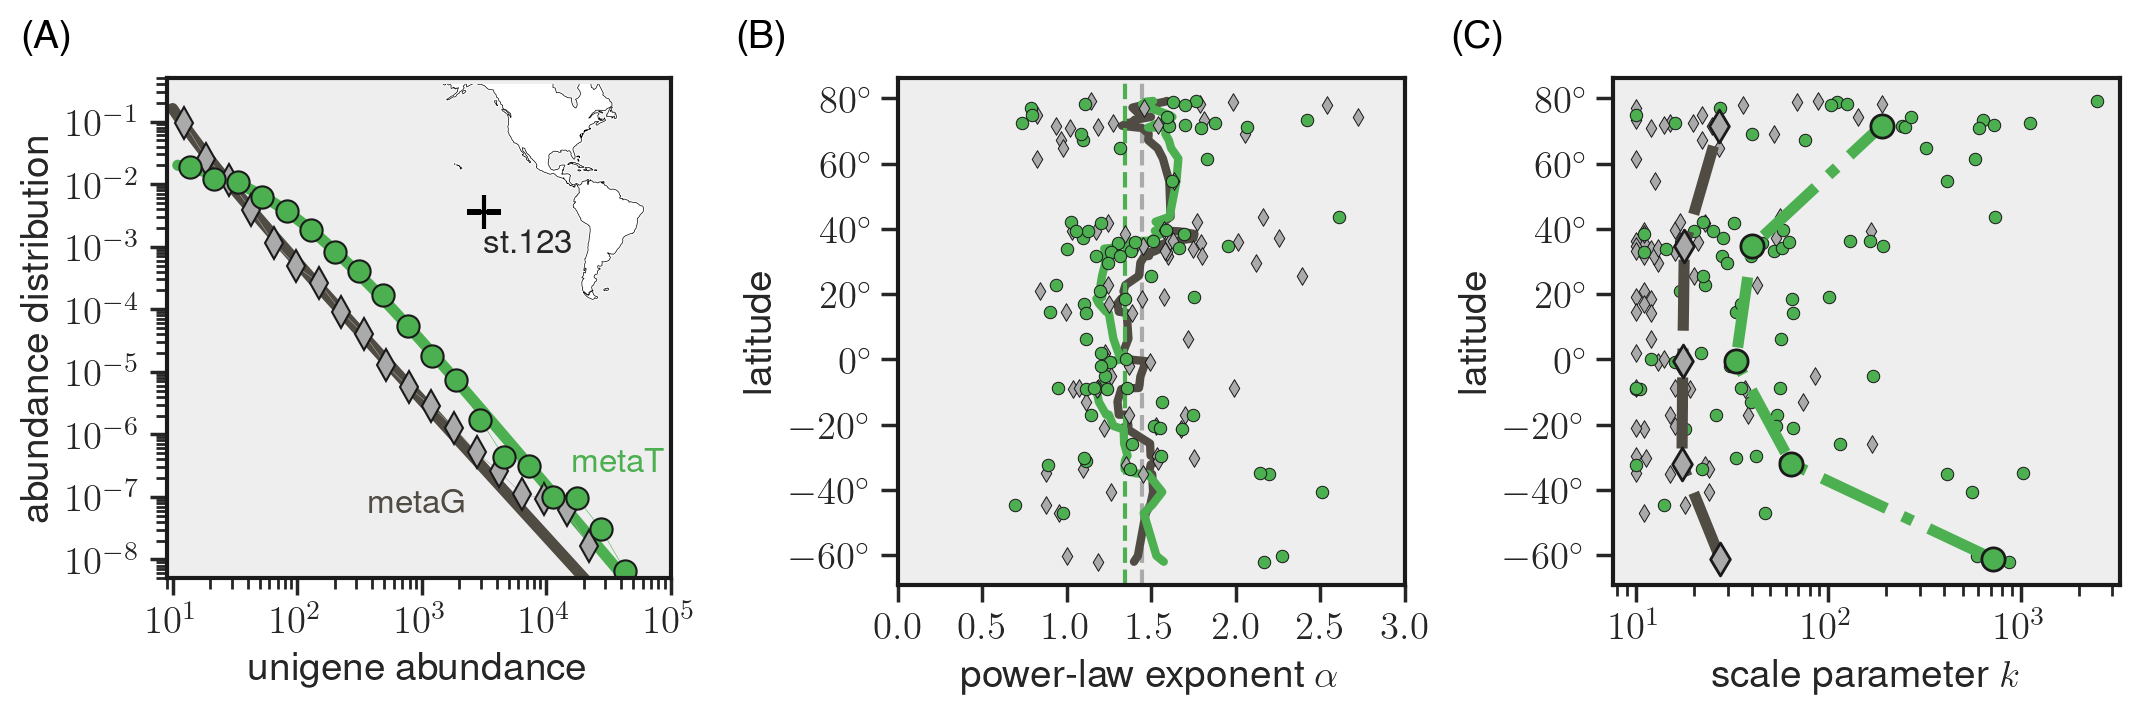

In [19]:
height = 3.24931369
phi = golden  # Use the already defined golden ratio

background_color = '#EEEEEE'

fig, ax = plt.subplots(figsize=(height, height), constrained_layout=False)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"unigene abundance")
ax.set_ylabel(r"abundance distribution")
ax.set_ylim(5e-9, 5e-1)
ax.set_xlim(0.9e1, 1e5)
ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax.xaxis.set_major_formatter(LogFormatterMathtext())
ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax.yaxis.set_major_formatter(LogFormatterMathtext())
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
ax.set_yticks([1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
ax.set_xticks([1e1, 1e2, 1e3, 1e4, 1e5])

station = 123
for meta in ['metaG', 'metaT']:
    df = df_meta[meta]
    data = df[station]
    fit = df_fits[meta].loc[station]
    k, alpha, gamma, mu = 10**fit['logk'], fit['alpha'], 1, fit['mu_KS']
    data = data[~data.isna()]
    data = data[data >= mu]

    x, y = plot_logSAD(data, nbins=20)
    if meta == 'metaG':
        markeredgecolor = 'k'
        color = '#AAAAAA'
    else:
        markeredgecolor = 'k'
        color = metacolor[meta]
    sns.lineplot(x=x, y=y, ax=ax, color=color, lw=.2, marker=metamarker[meta], markersize=8, markeredgecolor=markeredgecolor, alpha=1)

    x_plot = np.logspace(np.log10(1.00001 * data.min()), np.log10(data.max()), 100)
    y_plot = [paretoDistribution(xx, k, alpha, gamma, mu) for xx in x_plot]
    sns.lineplot(x=x_plot, y=y_plot, ax=ax, color=metacolor[meta], lw=4., ls='-', zorder=-1, alpha=1)

ax.set_facecolor(background_color)

inset_ax = fig.add_axes([0.52, 0.52, 0.35, 0.35], projection=ccrs.Mercator())
inset_ax.coastlines(linewidth=0.25)
inset_ax.set_extent([-180, -30, -60, 60], crs=ccrs.PlateCarree())
inset_ax.scatter(metadata.loc[station, 'longitude'], metadata.loc[station, 'latitude'], marker='+', color='black', s=150, zorder=10, transform=ccrs.PlateCarree())
inset_ax.add_feature(cfeature.OCEAN, color=background_color)
inset_ax.add_feature(cfeature.LAND, color='white')
inset_ax.set_axis_off()
txt = f"st.{station}"
inset_ax.text(metadata.loc[station, 'longitude'], metadata.loc[station, 'latitude'] - 20, txt, fontsize=12, ha='left', va='center', transform=ccrs.PlateCarree())

text = 'metaG'
ax.text(0.5, 0.15, text, transform=ax.transAxes, ha='center', va='center', fontsize=12, color=metacolor['metaG'],
        bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
text = 'metaT'
ax.text(0.9, 0.2, text, transform=ax.transAxes, ha='center', va='bottom', fontsize=12, color=metacolor['metaT'],
        bbox=dict(facecolor='none', edgecolor='none', pad=3.0))

gdf = metadata.copy()
gdf = metadata.merge(df_fits['metaT'], left_index=True, right_index=True)
gdf['k'] = gdf['k_KS_model']

ax1 = fig.add_axes([1.25, 0.1, 0.78, 0.78])
ax0 = fig.add_axes([2.35, 0.1, 0.78, 0.78])

ax0.set_ylabel('latitude')
ax0.set_xlabel(r'scale parameter $k$')
ax0.set_xscale('log')
lats = [-60, -40, -20, 0, 20, 40, 60, 80]
ax0.set_yticks(lats)
ax0.set_yticklabels([r"${}^\circ$".format(lat) for lat in lats])

for meta in ['metaG', 'metaT']:
    gdf = metadata.copy()
    gdf = metadata.merge(df_fits[meta], left_index=True, right_index=True)
    gdf['k'] = gdf['k_KS_model']
    if meta == 'metaG':
        color = '#AAAAAA'
        marker = metamarker['metaG']
    else:
        color = metaTcolor
        marker = metamarker['metaT']

    sns.scatterplot(x='k', y='latitude', data=gdf, edgecolor='k', s=20, zorder=2, color=color, ax=ax0, label=meta, marker=marker)

    latitudes = [-90, -50, -20, 20, 50, 90]
    lats = []
    ks = []
    lower_errors, upper_errors = [], []
    for lat_index in range(len(latitudes) - 1):
        lat_inf, lat_sup = latitudes[lat_index], latitudes[lat_index + 1]
        gdf_lat = gdf[(gdf['latitude'] >= lat_inf) & (gdf['latitude'] < lat_sup)]
        lats.append(gdf_lat['latitude'].mean())
        logk_mean = np.log10(gdf_lat['k']).mean()
        logk_std = np.log10(gdf_lat['k']).std()
        ks.append(10 ** logk_mean)
        lower_errors.append(-10 ** (logk_mean - logk_std) + 10 ** logk_mean)
        upper_errors.append(10 ** (logk_mean + logk_std) - 10 ** logk_mean)
    ax0.plot(ks, lats, lw=4, ls='-.', zorder=10, color=metacolor[meta], marker='s', markersize=0, alpha=1)
    ax0.scatter(ks, lats, color=color, alpha=1, marker=marker, s=70, edgecolor='k', zorder=10)

ax0.legend().remove()
ax0.set_facecolor(background_color)

ax1.set_ylabel('latitude')
lats = [-60, -40, -20, 0, 20, 40, 60, 80]
ax1.set_yticks(lats)
ax1.set_yticklabels([r"${}^\circ$".format(lat) for lat in lats])
ax1.set_xlabel(r'power-law exponent $\alpha$')
ax1.set_xlim(0., 3.)
ax1.set_xticks(np.arange(0, 3.1, 0.5))

for meta in ['metaG', 'metaT']:
    gdf = metadata.copy()
    gdf = metadata.merge(df_fits[meta], left_index=True, right_index=True)
    if meta == 'metaG':
        color = '#AAAAAA'
        marker = metamarker['metaG']
    else:
        color = metaTcolor
        marker = metamarker['metaT']

    sns.scatterplot(x='alpha', y='latitude', data=gdf, edgecolor='k', s=20, zorder=2, color=color, ax=ax1, label=meta, marker=marker)
    latitudes = [-90, -50, -20, 20, 50, 90]
    lats = []
    alphas = []
    lower_errors, upper_errors = [], []
    for lat_index in range(len(latitudes) - 1):
        lat_inf, lat_sup = latitudes[lat_index], latitudes[lat_index + 1]
        gdf_lat = gdf[(gdf['latitude'] >= lat_inf) & (gdf['latitude'] < lat_sup)]
        lats.append(gdf_lat['latitude'].mean())
        alpha_mean = gdf_lat['alpha'].mean()
        alpha_std = gdf_lat['alpha'].std()
        alphas.append(alpha_mean)
        lower_errors.append(-alpha_mean + alpha_std)
        upper_errors.append(alpha_mean + alpha_std - alpha_mean)
    ax1.axvline(gdf['alpha'].median(), lw=1.5, ls='--', zorder=1, color=color)

    plot_moving_average = True
    if plot_moving_average:
        lats = gdf.sort_values("latitude").loc[:, "latitude"].values
        alphas_mean = gdf.sort_values("latitude").loc[:, "alpha"].values
        window_size = 15
        moving_avg_neg, moving_avg_pos = [], []
        for i in range(len(lats[lats < 0])):
            moving_avg_neg.append(alphas_mean[i:i+window_size].mean())
            
        for j in range(len(lats[lats >= 0])):
            moving_avg_pos.append(alphas_mean[len(lats) - j - window_size:len(lats) - j].mean())
        moving_avg = np.concatenate((moving_avg_neg, moving_avg_pos[::-1]))
        ax1.plot(moving_avg, lats, lw=3, color=metacolor[meta], ls='-', zorder=1)

ax1.legend().remove()
ax1.set_facecolor(background_color)

fig.text(-0.1, 0.97, '(A)', ha='left', va='top', fontsize=14, color='black', usetex=False)
fig.text(1., 0.97, '(B)', ha='left', va='top', fontsize=14, color='black', usetex=False)
fig.text(2.1, 0.97, '(C)', ha='left', va='top', fontsize=14, color='black', usetex=False)

figname = '../figures/fig3'
plt.savefig(f'{figname}.png', dpi=300, bbox_inches='tight', transparent=False)
plt.show()
